# Multilayer Perceptron code for Digit Classification

The notebook walks through the MLP (Shallow Neural Network) with a hidden layer of size 1000 units and output layer of 10 units. The notebook provides the computational graph perspective of the MLP by implementing the forward propagation, cost function and backward propagation functions. 

The network is trained for 10 epochs with a random minibatch size of 5 on the training dataset of size 50,000 images. It is tested on the validation dataset of 10,000 images which achieved an accuracy of 92.73%.

In [26]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import gzip
import pickle
%matplotlib inline

In [2]:
def load_dataset(dataset):
    #Assumes mnist is downloaded and in the same path as this notebook
    # Load the dataset
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    f.close()

    Xtrain = np.array(train_set[0]).T
    Ytrain = np.array(train_set[1])
    Ytrain = Ytrain.reshape((1,Ytrain.shape[0]))
    Xvalid = np.array(valid_set[0]).T
    Yvalid = np.array(valid_set[1])
    Yvalid = Yvalid.reshape((1, Yvalid.shape[0]))
    Xtest = np.array(test_set[0]).T
    Ytest = np.array(test_set[1])
    Ytest = Ytest.reshape((1, Ytest.shape[0]))

    return Xtrain, Ytrain, Xvalid, Yvalid, Xtest, Ytest

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 5, seed = 0):
    '''
    Parameters:   
    X - Input data of size (n_x, m) 
    Y - True labels vector (1, m) 
    mini_batch_size - size of minibatches, integer 
    
    Returns:
    mini_batches - list of synchronous (mini_batch_X, mini_batch_Y)
    '''
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    #Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))    #Randomly permute a sequence
    shuffled_X = X[:, permutation]      #Shuffles examples column-wise
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    #Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_batches = math.floor(m/mini_batch_size) #Number of mini batches of size mini_batch_size in your partioning.
    for k in range(0, num_complete_batches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size: (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: (k+1) * mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    #Handline the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        #end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_X = shuffled_X[:, num_complete_batches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_batches * mini_batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [4]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    n_x - size of input layer
    n_h - size of hidden layer
    n_y - size of output layer
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
                
    return parameters

In [5]:
def softmax(Z):
    return np.exp(Z)/np.sum(np.exp(Z),axis = 0)  #A.shape = (n_y, m)
    #return np.argmax(A,axis = 0).reshape(1, A.shape[1]) #Output shape = (1, m)

In [6]:
def forward_propagation(X, parameters):
    '''
    Parameters:
    X - Input data of size (n_x, m)
    parameters - python dictionary containing the parameters of the model
    
    Returns:
    A2 - The softmax output of the output layer activation
    cache - a dictionary containing "Z1", "A1", "Z2" and "A2"
    '''
    
    #Retrieve parameters from the dictionary parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #Forward propagation
    Z1 = np.dot(W1,X) + b1
    A1 = Z1
    Z2 = np.dot(W2,A1) + b2
    A2 = softmax(Z2)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2
            }
    
    return A2, cache

In [7]:
def compute_cost(A2, Y):
    '''
    Parameters:
    A2 - The activation of the output layer of size (n_y, m)
    Y - True labels of size (1, m)
    
    Returns:
    cost - cross entropy cost given parameters
    '''
    
    #compute the cross entropy cost
    m = Y.shape[1]
    cost = -np.squeeze((np.sum(np.log(A2[Y,np.arange(A2.shape[1])]))))/m
    
    return cost
    

In [8]:
def backward_propagation(X, Y, cache, parameters):
    '''
    Parameters:
    parameters - dictionary containing the parameters of the model
    cache - dictionary containing 'Z1', 'A1', 'Z2', 'A2'
    X - Input data of size (n_x, m)
    Y - True labels of size (1, m)
    
    Returns:
    grads - dictionary containing gradients w.r.t to different parameters
    '''
    
    m = X.shape[1]
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    Y = np.array([[1 if j == i else k for j, k in enumerate([0 for a in range(10)])] for i in Y.reshape(-1)]).T   #Converts the true label vectors from (1, m) to (n_y, m)
    dZ2 = A2 - Y 
    dW2 = np.dot(dZ2, A1.T)/m
    db2 = np.sum(dZ2, axis = 1, keepdims=True)/m
    dZ1 = np.dot(W2.T, dZ2)/m
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1, axis = 1, keepdims = True)/m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2
            }
    
    return grads

In [9]:
def update_parameters(parameters, grads, learning_rate = 0.01):
    '''
    Parameters:
    parameters - dictionary containing parameters of the model
    grads - dictionary containing gradients w.r.t. to the parameters of the model
    
    Returns:
    parameters: dictionary containing updated parameters of the model
    '''
    
    L = len(parameters) // 2
    for l in range(1,L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * grads['db'+str(l)]
        
    return parameters

In [21]:
def mlp(X, Y, num_iterations = 10, learning_rate=0.01, mini_batch_size = 5, print_cost = False):
    '''
    Parameters:
    X - input data of size (n_x, m)
    Y - True labels of size (1, m)
    num_iterations - number of epochs for the training of the model
    print_cost - if True print the cost for every 10 iterations
    
    Returns:
    parameters - parameters learned by the model. They can be used to predict later.
    '''
    layers_dims = [X.shape[0], 1000, 10]
    parameters = initialize_parameters(layers_dims)
    costs = []
    
    for i in range(0, num_iterations):
        
        minibatches = random_mini_batches(X, Y, mini_batch_size, 0)
        
        for minibatch in minibatches:
            
            (minibatch_X, minibatch_Y) = minibatch
        
            A2, cache = forward_propagation(minibatch_X, parameters)
            
            cost = compute_cost(A2, minibatch_Y)
            
            grads = backward_propagation(minibatch_X, minibatch_Y, cache, parameters)
            
            parameters = update_parameters(parameters, grads)
            
        if print_cost and i % 1 == 0:
            costs.append(cost)
        if print_cost and i % 1 == 0:
                print ("Cost after iteration %i: %f" % (i, cost))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    with open('model.pkl', 'wb') as handle:
        pickle.dump(parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

                
    return parameters 
    
    

In [18]:
def predict(parameters, X):
    '''
    Parameters:
    parameters - dictionary containing the parameters of the model.
    X - Input data of size (n_x, m)
    
    Returns:
    predictions - vector of predictions of our model of size (1, m)
    '''
    
    A2, cache = forward_propagation(X, parameters)
    predictions = np.argmax(A2, axis = 0).reshape(1, A2.shape[1])
    
    return predictions

In [19]:
Xtrain, Ytrain, Xvalid, Yvalid, Xtest, Ytest = load_dataset('mnist.pkl.gz')
print(Xtrain.shape, Ytrain.shape,Xvalid.shape, Yvalid.shape, Xtest.shape, Ytest.shape)

(784, 50000) (1, 50000) (784, 10000) (1, 10000) (784, 10000) (1, 10000)


Cost after iteration 0: 0.020517


Cost after iteration 1: 0.015128


Cost after iteration 2: 0.015050


Cost after iteration 3: 0.015258


Cost after iteration 4: 0.015324


Cost after iteration 5: 0.015268


Cost after iteration 6: 0.015131


Cost after iteration 7: 0.014945


Cost after iteration 8: 0.014727


Cost after iteration 9: 0.014492


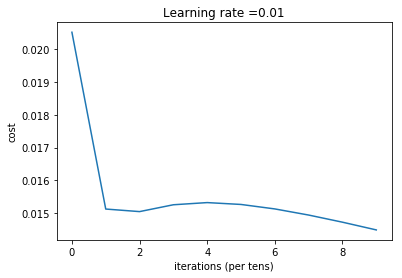

In [23]:
parameters = mlp(Xtrain, Ytrain, num_iterations=10, learning_rate=0.01, mini_batch_size= 5, print_cost=True)

In [24]:
def test(Xvalid, Yvalid, parameters):

    test_loss, test_acc, test_count = 0,0,0

    predictions = predict(parameters, Xvalid)
    
    test_acc += np.sum(predictions == Yvalid)
    
    #test_loss = test_loss / test_count
    test_acc = test_acc / Xvalid.shape[1]

    print('\nTest Accuracy = ' + str(test_acc))

In [25]:
with open('model.pkl', 'rb') as handle:
    parameters = pickle.load(handle)
test(Xvalid, Yvalid, parameters)


Test Accuracy = 0.9273
